# Load Application Import, Data Analysis and Visualization

### 4. Functional Requirements - LOAN Application Dataset


In [47]:
import requests
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, FloatType
import mariadb
import matplotlib.pyplot as plt




Create a Python program to GET (consume) data from the API endpoint for the loan application dataset.
 
Functional Requirements 4.1



In [8]:
def get_load_data():
    return requests.get("https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json")
    

resp = get_load_data()
df_loan = pd.DataFrame(resp.json())
df_loan.head()

,Application_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status
0,LP001002,Male,No,0,Graduate,No,1,Urban,medium,Y
1,LP001003,Male,Yes,1,Graduate,No,1,Rural,medium,N
2,LP001005,Male,Yes,0,Graduate,Yes,1,Urban,low,Y
3,LP001006,Male,Yes,0,Not Graduate,No,1,Urban,low,Y
4,LP001008,Male,No,0,Graduate,No,1,Urban,medium,Y


Find the status code of the above API endpoint.
 (Hint: status code could be 200, 400, 404, 401.)
 
Functional Requirements 4.2



In [9]:
resp.status_code

200

Once Python reads data from the API, utilize PySpark to load data into RDBMS (SQL). The table name should be CDW-SAPP_loan_application in the database.

Functional Requirements 4.3



In [17]:
spark = SparkSession.builder.appName("loan").getOrCreate()

schema_loans = StructType([
                            StructField("Application_ID", StringType()),
                            StructField("Gender", StringType()),
                            StructField("Married", StringType()),
                            StructField("Dependents", StringType()),
                            StructField("Education", StringType()),
                            StructField("Self_Employed", StringType()),
                            StructField("Credit_History", StringType()),
                            StructField("Property_Area", StringType()),
                            StructField("Income", StringType()),
                            StructField("Application_Status", StringType())
])

In [20]:
loans_df = spark.createDataFrame(get_load_data().json(), schema=schema_loans)
loans_df.show()

+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|Application_ID|Gender|Married|Dependents|   Education|Self_Employed|Credit_History|Property_Area|Income|Application_Status|
+--------------+------+-------+----------+------------+-------------+--------------+-------------+------+------------------+
|      LP001002|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|
|      LP001003|  Male|    Yes|         1|    Graduate|           No|             1|        Rural|medium|                 N|
|      LP001005|  Male|    Yes|         0|    Graduate|          Yes|             1|        Urban|   low|                 Y|
|      LP001006|  Male|    Yes|         0|Not Graduate|           No|             1|        Urban|   low|                 Y|
|      LP001008|  Male|     No|         0|    Graduate|           No|             1|        Urban|medium|                 Y|


Load data into the database

In [24]:
with open('../.secrets', 'r') as f:
    CREDITCARD_CAPSTONE_PASSWORD = f.read()

loans_df.write.format("jdbc").mode("append")\
                .option("driver", "com.mysql.cj.jdbc.Driver")\
                .option("url", "jdbc:mysql://mikey.helioho.st:3306/michaelwschmidt_creditcard_capstone")\
                .option("user", "michaelwschmidt_cc_capstone")\
                .option("dbtable","cdw_sapp_loan_application")\
                .option("password", CREDITCARD_CAPSTONE_PASSWORD)\
                .option("header", "false")\
                .save()

### 5. Functional Requirements - Data Analysis and Visualization for LOAN Application

Functional Requirements 5.1

Find and plot the percentage of applications approved for self-employed applicants.




In [30]:
def query_db(query, printable=True):
    try:
        with open('../.secrets', 'r') as f:
            CREDITCARD_CAPSTONE_PASSWORD = f.read()

        conn = mariadb.connect(
            user="michaelwschmidt_cc_capstone",
            password=CREDITCARD_CAPSTONE_PASSWORD,
            host="tommy2.heliohost.org",
            port=3306,
            database="michaelwschmidt_creditcard_capstone"
        )

        cur = conn.cursor()
        cur.execute(query)
        rows = cur.fetchall()
        df = pd.read_sql_query(query, conn)

    except mariadb.Error as e:
        print(f"ERROR connecting to MariaDB:  {e}")

    finally:
        conn.close()
        if not df.empty:
            return df
        else:
            print("DATAFRAME IS EMPTY!  Something went wrong!")


In [77]:
self_emp_df = query_db("SELECT application_status, count(application_status) count FROM cdw_sapp_loan_application WHERE self_employed='Yes' GROUP BY 1")
self_emp_df = self_emp_df.replace(['Y'], 'Accepted').replace(['N'], 'Rejected') 
self_emp_df = self_emp_df.set_index(self_emp_df.columns[0])

self_emp_df.head()

C:\Users\mikey\AppData\Local\Temp\ipykernel_20992\1276811265.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,count
application_status,
Rejected,24
Accepted,46


''

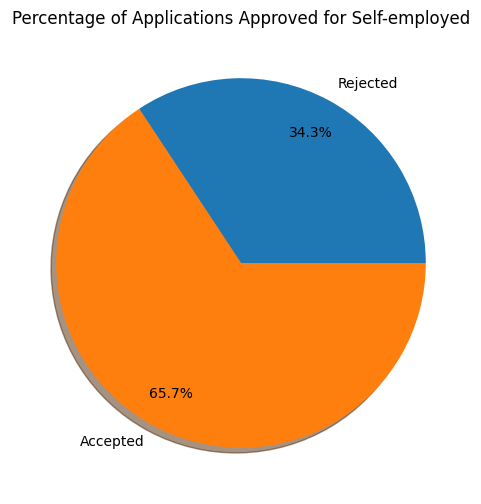

In [79]:
self_emp_df["count"].plot(kind="pie",
                            figsize=(15,6),
                            autopct='%1.1f%%',
                            shadow=True,
                            pctdistance=.80,
                            explode=[0, 0])

plt.title("Percentage of Applications Approved for Self-employed")
plt.ylabel('')
;

Functional Requirements 5.2

Find the percentage of rejection for married male applicants.




In [81]:
married_male_df = query_db("SELECT application_status, count(self_employed) count \
                        FROM cdw_sapp_loan_application \
                        WHERE married = 'Yes' \
                        AND gender = 'Male' \
                        GROUP BY 1")
married_male_df = self_emp_df.replace(['Y'], 'Accepted').replace(['N'], 'Rejected') 

married_male_df.head()

C:\Users\mikey\AppData\Local\Temp\ipykernel_20992\1276811265.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,count
application_status,
Rejected,24
Accepted,46


''

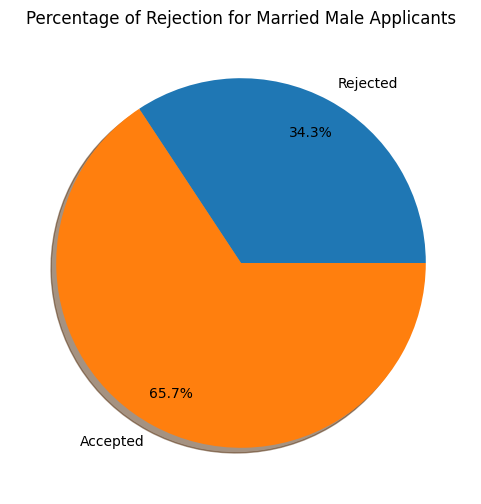

In [82]:
married_male_df["count"].plot(kind="pie",
                            figsize=(15,6),
                            autopct='%1.1f%%',
                            shadow=True,
                            pctdistance=.80,
                            explode=[0, 0])

plt.title("Percentage of Rejection for Married Male Applicants")
plt.ylabel('')
;

Functional Requirements 5.3

Find and plot the top three months with the largest transaction data.




C:\Users\mikey\AppData\Local\Temp\ipykernel_20992\1276811265.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


''

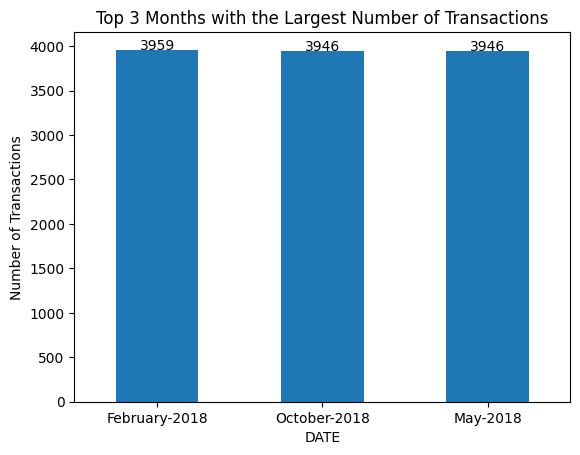

In [128]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha='center')

top_3_months_trans_df = query_db("SELECT CONCAT( DATE_FORMAT(DATE(timeid),'%M'),'-', YEAR(DATE(timeid)) ) date, count(*) count  \
                                 FROM cdw_sapp_credit_card \
                                 GROUP BY 1 \
                                 ORDER BY count desc \
                                 LIMIT 3")
top_3_months_trans_df.head()
top_3_months_trans_df.set_index("date", inplace=True)
top_3_months_trans_df.plot(kind='bar', legend=False)
plt.title("Top 3 Months with the Largest Number of Transactions")
plt.xlabel("DATE")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=0)
addlabels(top_3_months_trans_df.index, top_3_months_trans_df['count'])
;

Functional Requirements 5.4

Find and plot which branch processed the highest total dollar value of healthcare transactions.



In [146]:
branch_highest_healthcare_df = query_db("SELECT b.branch_code, sum(transaction_value) total \
                                FROM cdw_sapp_credit_card cc \
                                JOIN cdw_sapp_branch b \
                                    ON cc.BRANCH_CODE = b.BRANCH_CODE \
                                WHERE transaction_type = 'Healthcare' \
                                GROUP BY b.branch_code \
                                ORDER BY 2 desc \
                                LIMIT 10")

#branch_highest_healthcare_df.set_index("branch_code", inplace=True)
branch_highest_healthcare_df['branch_code'] = branch_highest_healthcare_df['branch_code'].astype('str')
branch_highest_healthcare_df

C:\Users\mikey\AppData\Local\Temp\ipykernel_20992\1276811265.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,branch_code,total
0,25,4370.18
1,60,4072.04
2,83,4003.37
3,36,3823.87
4,111,3720.27
5,90,3697.16
6,21,3651.74
7,109,3603.67
8,42,3603.25
9,70,3594.35


''

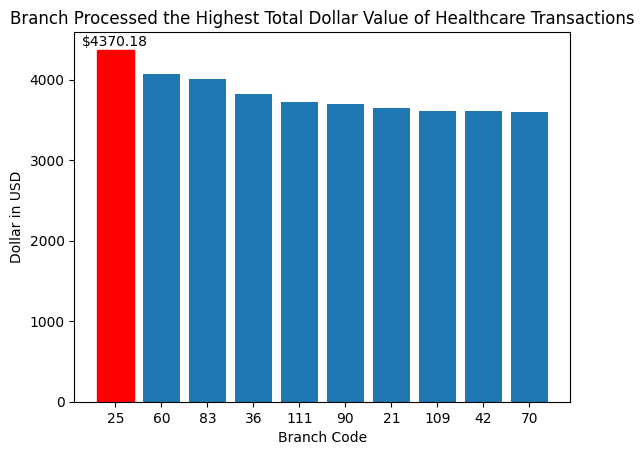

In [163]:
p = plt.bar(branch_highest_healthcare_df['branch_code'], branch_highest_healthcare_df['total'])
p[0].set_color('r')
plt.text(0, branch_highest_healthcare_df['total'][0]+50, "$"+str(branch_highest_healthcare_df['total'][0]), ha='center')
plt.title("Branch Processed the Highest Total Dollar Value of Healthcare Transactions")
plt.xlabel("Branch Code")
plt.ylabel("Dollar in USD")
;